#TWristAR_load_dataset.ipynb
Loads the raw e4 signals and .csv label files from the [Zenodo repository](https://zenodo.org/record/5911808) and returns train and test X/y numpy arrays.

The basic flow is:
* Download and unzip the dataset if not already present
* Convert each recording *session* into Intermediate Representation 1 (IR1) format - a datetime indexed pandas dataframe with columns for each channel plus the label and subject number.
* Transform the IR1 into IR2 - a set of three numpy arrays containing sliding window samples
   * X = (samples, time steps per sample, channels)  
   * y =  (samples, label) # activity classification  
   * s =  (samples, subject) # subject number
* Clean and further transforms the IR2 arrays as needed - note the transforms that can be applied here are train vs test dependent.   For example, the IR2 arrays in the training set may be rebalanced, but those in the test set should not.
* Concatenate the processed IR2 arrays into the final returned train/validate/test arrays.

TWRistAR is small and easily downloadable so there is no option to used saved Intermediate Representations here as there is in some of the loaders for larger datasets.

Set interactive to true to run the Jupyter Notebook version.  Note most of the calls are setup to test the functions, not process the entire dataset, to do that set interactive to false and run all so that main executes.   This notebook can be saved and run as a python file as well.

This video describes the code https://mediaflo.txstate.edu/Watch/e4_data_processing. (updates have been made since this was made)


Acknowledgement to and a good example of the WISDM format being pre-processed is https://towardsdatascience.com/human-activity-recognition-har-tutorial-with-keras-and-core-ml-part-1-8c05e365dfa0  by Nils Ackermann.  


<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

[Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), Texas State University, [IMICS Lab](https://imics.wp.txstate.edu/)  
TODO:
* The IR3 transform could be further optimized by taking a dictionary of IR1 dataframes as was done in the later datasets.
* log_info needs to be updated to dictionary format so we can read things like the channel names automatically.
* Time is off by 6 hrs due to time zone issues - adjusted in Excel/csv but would be good to show it in the correct time zone.
* Need to incorporate session numbers or just use the alternate .csv files where validation was 'fake' subs 11 and 22 which were just a few of the sessions from subjects 1 and 2.  This was done in the Semi-Supervised version of the loader for WISHWell but not integrated back into this version.


# Import Libraries and Common Load Dataset Code (from IMICS public repo)

In [1]:
import os
import shutil #https://docs.python.org/3/library/shutil.html
from shutil import unpack_archive # to unzip
import time
import pandas as pd
import numpy as np
from numpy import savetxt
from tabulate import tabulate # for verbose tables, showing data
from tensorflow.keras.utils import to_categorical # for one-hot encoding
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from time import gmtime, strftime, localtime #for displaying Linux UTC timestamps in hh:mm:ss
from datetime import datetime, date
import urllib.request # to get files from web w/o !wget

In [2]:
def get_py_file(fname, url):
    """checks for local file, if none downloads from URL.    
    :return: nothing"""
    #fname = 'load_data_utils.py'
    #ffname = os.path.join(my_dir,fname)
    if (os.path.exists(fname)):
        print ("Local",fname, "found, skipping download")
    else:
        print("Downloading",fname, "from IMICS git repo")
        urllib.request.urlretrieve(url, filename=fname)

get_py_file(fname = 'load_data_utils.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_utils.py')
get_py_file(fname = 'load_data_transforms.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_transforms.py')

In [3]:
# common transforms and utils used by the individual loaders
import load_data_transforms as xform
import load_data_utils as utils

# Global and Dataset Parameters

In [4]:
# environment and execution parameters
my_dir = '.' # replace with absolute path if desired
dataset_dir = my_dir # TWristAR zip file contains TWristAR directory
working_dir = os.path.join(my_dir,'TWristAR_temp') # temp dir for processing

if not os.path.exists(working_dir):
    os.makedirs(working_dir)
interactive = True # for exploring data and functions interactively
verbose = True

# dataset parameters
all_channel_list = ['accel_x', 'accel_y', 'accel_z','accel_ttl','bvp','eda','p_temp']
# frequency = 32 - note this is hardcoded due to the unique sample freqencies
# that differ between the individual e4 sensors
xform.time_steps = 96 # three seconds at 32Hz
xform.stride = 32 # one second step for each sliding window
# The label_map_<dataset> contains a mapping from strings to ints for all
# possible labels in the entire dataset.   This allows for predictable conversion
# regardless of the slices.  I'm using 99 for 'unknown' which will be dropped
# to avoid the confusion of shifing by 1 place, zero indexed etc.
# Also this label map dict is setup to handle multi-labels but TWRristAR 
# has only a single activity label.
label_map_twristar = {"label":     {"Downstairs": 0, "Jogging": 1, "Sitting": 2,
                                "Standing": 3, "Upstairs": 4, "Walking": 5,
                                "Undefined": 99}}
scripted = True # TWristAR has two categories of data - scripted activities
                # and unscripted, set to false to get the unscripted data.
                # See example in bottom of this notebook.

In [5]:
interactive = False # don't run if interactive, automatically runs for .py version
verbose = False # to limit the called functions output

In [5]:
def get_TWristAR():
    """checks for local zipfile, if none downloads from zenodo repository
    after download will unzip the dataset into TWristAR directory.
    Assumes a global my_dir has been defined (default is my_dir = ".")
    :return: nothing"""
    zip_ffname = os.path.join(my_dir,'TWristAR.zip')
    if (os.path.exists(zip_ffname)):
        if verbose:
            print ("Local TWristAR.zip found, skipping download")
    else:
        print("Downloading TWristAR from Zenodo")
        urllib.request.urlretrieve("https://zenodo.org/record/5911808/files/TWristAR.zip", filename="TWristAR.zip")
    if (os.path.isdir(os.path.join(dataset_dir,'TWristAR'))):
        if verbose:
            print("Found existing TWristAR directory, skipping unzip")
        return
    else:
        print("Unzipping TWristAR file in", dataset_dir, "directory")
        if (os.path.exists(zip_ffname)):
            shutil.unpack_archive(zip_ffname,dataset_dir,'zip')
        else:
            print("Error: ", zip_ffname, " not found, exiting")
            return
if interactive:
    get_TWristAR()

Unzipping TWristAR file in . directory


In [6]:
def unzip_e4_file(zip_ffname):
    """checks for local copy, if none unzips the e4 zipfile in working_dir
    Note:  the files themselves do not contain subject info and there are
    multiple files e.g. ACC.csv, BVP,csv etc, in each zipfile.
    It is very important to further process the files with <fname>_labels.csv
    :param zip_ffname: the path and filename of the zip file
    :param working_dir: local (colab) directory where csv files will be placed
    :return: nothing"""
    if not os.path.exists(working_dir):
        print("Error working directory", working_dir, "not found, unzip_e4_file exiting")
        return
    if (os.path.exists(zip_ffname)):
        if verbose:
            print("Unzipping",zip_ffname, "in", working_dir)
        shutil.unpack_archive(zip_ffname,working_dir,'zip')
    else:
        print("Error: ", zip_ffname, " not found, exiting")
        return
if interactive:
    zip_ffname = os.path.join(my_dir,'TWristAR','sub1/1574621345_A01F11.zip')
    unzip_e4_file(zip_ffname)

Unzipping ./TWristAR/sub1/1574621345_A01F11.zip in ./TWristAR_temp


In [7]:
def df_from_e4_csv (ffname,col_labels):
    """"reads e4 ACC, BVP, EDA, or TEMP(erature) csv files, uses start time and
    sample rate to create time indexed pandas dataframe with columns.  
    Note the other e4 files have different format and must be read seperately. 
    :param ffname:  full filename e.g./content/temp/ACC.csv
    :col_labels: list of colums in csv - varies by type ['accel_x','accel_y...]
    :returns df: time indexed dataframe"""

    df = pd.read_csv(ffname, header=None)
    start_time = df.iloc[0,0].astype('int64') # first line in e4 csv
    sample_freq = df.iloc[1,0].astype('int64') # second line in e4 csv
    df = df.drop(df.index[[0,1]]) # drop 1st two rows, index is now off by 2
    # Convert the index to datetime to allow for pandas resampling
    # The start_time from the e4 csv file is forced to int64 which represents the
    # number of nanoseconds since January 1, 1970, 00:00:00 (UTC)
    # This is tricky - if float representation the join function may not work
    # properly later since the indexes must match exactly.
    # UTC_time is computed for each row, then made into required datetime format
    # which is a int64 that pandas will accept as an index
    df['UTC_time'] = (df.index-2)/sample_freq + start_time
    end_time = df['UTC_time'].iloc[-1]
    if verbose:
        print(ffname, "Sample frequency = ", sample_freq, " Hz")
        #show time in day month format, assumes same timezone
        print("File start time = ", strftime("%a, %d %b %Y %H:%M:%S", localtime(start_time)))  
        print("File end time   = ",strftime("%a, %d %b %Y %H:%M:%S", localtime(end_time)))
    df['datetime'] = pd.to_datetime(df['UTC_time'], unit='s')
    df.set_index('datetime',inplace=True)
    df = df.drop('UTC_time', axis=1)
    df.columns = col_labels
    return df
if interactive:
    # Note: IBI.csv is the inter-beat interval, a calculated value with a 
    # different format.  HR.csv is also calculated from BVP but format is same.
    ffname = working_dir + '/ACC.csv'
    col_labels = ['accel_x', 'accel_y', 'accel_z']
    ir1_acc_df = df_from_e4_csv(ffname, col_labels)
    print("ACC dataframe shape", ir1_acc_df.shape)
    display(ir1_acc_df.head())

    ffname = working_dir + '/BVP.csv'
    col_labels = ['bvp']
    ir1_bvp_df = df_from_e4_csv(ffname, col_labels)
    print("BVP dataframe shape", ir1_bvp_df.shape)
    display(ir1_bvp_df.head())

    ffname = working_dir + '/EDA.csv'
    col_labels = ['eda']
    ir1_eda_df = df_from_e4_csv(ffname, col_labels)
    print("EDA dataframe shape", ir1_eda_df.shape)
    display(ir1_eda_df.head())

    ffname = working_dir + '/TEMP.csv'
    col_labels = ['p_temp']
    ir1_temp_df = df_from_e4_csv(ffname, col_labels)
    print("Temp dataframe shape", ir1_temp_df.shape)
    display(ir1_temp_df.head())

./TWristAR_temp/ACC.csv Sample frequency =  32  Hz
File start time =  Sun, 24 Nov 2019 18:49:05
File end time   =  Sun, 24 Nov 2019 18:58:11
ACC dataframe shape (17502, 3)


,accel_x,accel_y,accel_z
datetime,,,
2019-11-24 18:49:05.000000000,-2.0,-26.0,57.0
2019-11-24 18:49:05.031249920,-3.0,-26.0,58.0
2019-11-24 18:49:05.062500096,-3.0,-26.0,58.0
2019-11-24 18:49:05.093750016,-4.0,-26.0,58.0
2019-11-24 18:49:05.124999936,-4.0,-26.0,58.0


./TWristAR_temp/BVP.csv Sample frequency =  64  Hz
File start time =  Sun, 24 Nov 2019 18:49:05
File end time   =  Sun, 24 Nov 2019 18:58:11
BVP dataframe shape (35002, 1)


,bvp
datetime,
2019-11-24 18:49:05.000000000,-0.0
2019-11-24 18:49:05.015624960,-0.0
2019-11-24 18:49:05.031249920,-0.0
2019-11-24 18:49:05.046874880,-0.0
2019-11-24 18:49:05.062500096,-0.0


./TWristAR_temp/EDA.csv Sample frequency =  4  Hz
File start time =  Sun, 24 Nov 2019 18:49:05
File end time   =  Sun, 24 Nov 2019 18:58:10
EDA dataframe shape (2184, 1)


,eda
datetime,
2019-11-24 18:49:05.000000000,0.000000
2019-11-24 18:49:05.249999872,0.840149
2019-11-24 18:49:05.500000000,1.187489
2019-11-24 18:49:05.750000128,1.625562
2019-11-24 18:49:06.000000000,2.103368


./TWristAR_temp/TEMP.csv Sample frequency =  4  Hz
File start time =  Sun, 24 Nov 2019 18:49:05
File end time   =  Sun, 24 Nov 2019 18:58:10
Temp dataframe shape (2184, 1)


,p_temp
datetime,
2019-11-24 18:49:05.000000000,31.83
2019-11-24 18:49:05.249999872,31.83
2019-11-24 18:49:05.500000000,31.83
2019-11-24 18:49:05.750000128,31.83
2019-11-24 18:49:06.000000000,31.83


In [8]:
def process_e4_accel(df):
    """converts component accel into g and adds accel_ttl column
    per info.txt range is [-2g, 2g] and unit in this file is 1/64g.
    This method is e4 specific due to the way the accelerations is recorded
    """
    df['accel_x'] = df['accel_x']/64
    df['accel_y'] = df['accel_y']/64
    df['accel_z'] = df['accel_z']/64
    df_sqd = df.pow(2)[['accel_x', 'accel_y', 'accel_z']] #square each accel
    df_sum = df_sqd.sum(axis=1) #add sum of squares, new 1 col df
    df.loc[:,'accel_ttl'] = df_sum.pow(0.5)-1  # sqrt and remove 1g due to gravity
    del df_sqd, df_sum
    return df
if interactive:
    ir1_acc_df = process_e4_accel(ir1_acc_df)
    display(ir1_acc_df.head())

,accel_x,accel_y,accel_z,accel_ttl
datetime,,,,
2019-11-24 18:49:05.000000000,-0.031250,-0.40625,0.890625,-0.020598
2019-11-24 18:49:05.031249920,-0.046875,-0.40625,0.906250,-0.005754
2019-11-24 18:49:05.062500096,-0.046875,-0.40625,0.906250,-0.005754
2019-11-24 18:49:05.093750016,-0.062500,-0.40625,0.906250,-0.004895
2019-11-24 18:49:05.124999936,-0.062500,-0.40625,0.906250,-0.004895


./TWristAR_temp/ACC.csv Sample frequency =  32  Hz
File start time =  Sun, 24 Nov 2019 18:49:05
File end time   =  Sun, 24 Nov 2019 18:58:11
./TWristAR_temp/BVP.csv Sample frequency =  64  Hz
File start time =  Sun, 24 Nov 2019 18:49:05
File end time   =  Sun, 24 Nov 2019 18:58:11
./TWristAR_temp/EDA.csv Sample frequency =  4  Hz
File start time =  Sun, 24 Nov 2019 18:49:05
File end time   =  Sun, 24 Nov 2019 18:58:10
./TWristAR_temp/TEMP.csv Sample frequency =  4  Hz
File start time =  Sun, 24 Nov 2019 18:49:05
File end time   =  Sun, 24 Nov 2019 18:58:10
IR1 full dataframe shape (17501, 7)


,accel_x,accel_y,accel_z,accel_ttl,bvp,eda,p_temp
datetime,,,,,,,
2019-11-24 18:49:05.000000000,-0.031250,-0.40625,0.890625,-0.020598,-0.00,0.000000,31.83
2019-11-24 18:49:05.031249920,-0.046875,-0.40625,0.906250,-0.005754,-0.00,0.105019,31.83
2019-11-24 18:49:05.062500096,-0.046875,-0.40625,0.906250,-0.005754,-0.00,0.210037,31.83
2019-11-24 18:49:05.093750016,-0.062500,-0.40625,0.906250,-0.004895,-0.00,0.315056,31.83
2019-11-24 18:49:05.124999936,-0.062500,-0.40625,0.906250,-0.004895,-0.00,0.420074,31.83
2019-11-24 18:49:05.156250112,-0.062500,-0.40625,0.906250,-0.004895,0.00,0.525093,31.83
2019-11-24 18:49:05.187500032,-0.046875,-0.40625,0.906250,-0.005754,0.01,0.630112,31.83
2019-11-24 18:49:05.218749952,-0.046875,-0.40625,0.906250,-0.005754,-0.03,0.735130,31.83
2019-11-24 18:49:05.249999872,-0.031250,-0.40625,0.890625,-0.020598,-0.05,0.840149,31.83


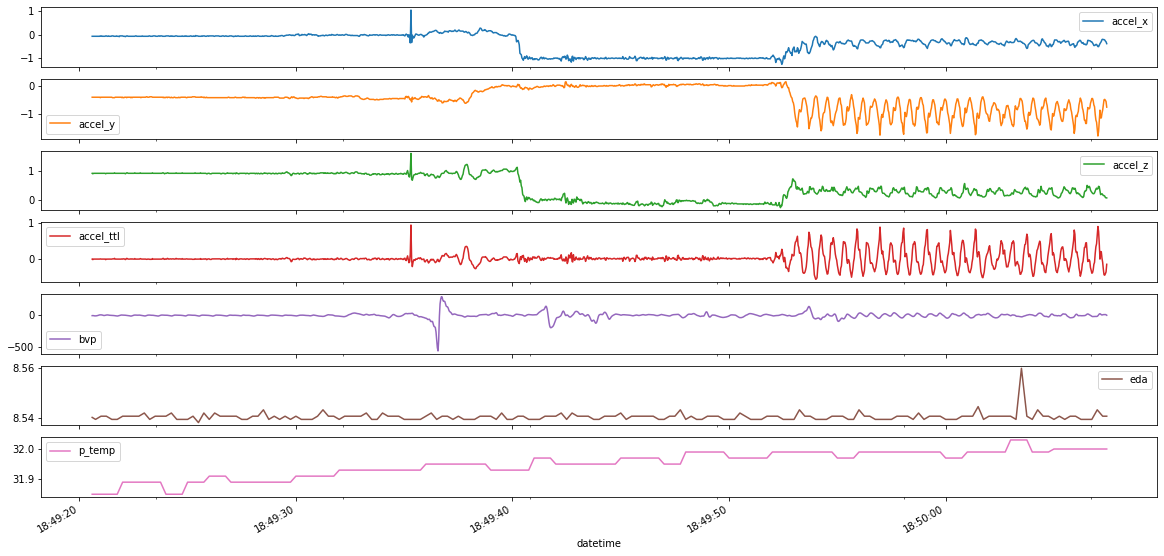

In [9]:
def get_ir1_from_e4_dir():
    """processes the four e4 sensor files in global working directory into a 
    single IR1 datetime indexed dataframe. Labeled columns are channels"""
    # Note: IBI.csv is the inter-beat interval, a calculated value with a 
    # different format.  HR.csv is also calculated from BVP but format is same.
    # TODO:  Should check directory for all four files and uniform start/stop
    # times.
    # TODO: Might be better to use a different interpolation.  See
    # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html
    ffname = working_dir + '/ACC.csv'
    col_labels = ['accel_x', 'accel_y', 'accel_z']
    ir1_acc_df = df_from_e4_csv(ffname, col_labels)
    ir1_acc_df = process_e4_accel(ir1_acc_df)

    ffname = working_dir + '/BVP.csv'
    col_labels = ['bvp']
    ir1_bvp_df = df_from_e4_csv(ffname, col_labels)

    ffname = working_dir + '/EDA.csv'
    col_labels = ['eda']
    ir1_eda_df = df_from_e4_csv(ffname, col_labels)

    ffname = working_dir + '/TEMP.csv'
    col_labels = ['p_temp']
    ir1_ptemp_df = df_from_e4_csv(ffname, col_labels)

    ir1_df = ir1_acc_df.join(ir1_bvp_df, how="inner") # this drops bvp to 32Hz
    ir1_df = ir1_df.join(ir1_eda_df, how="outer") # stays at 32Hz, eda fill NaN
    ir1_df = ir1_df.join(ir1_ptemp_df, how="outer") # stays at 32Hz, p_temp fill NaN
    ir1_df = ir1_df.interpolate() # default is linear interpolation
    ir1_df = ir1_df.astype('float32') # no need for 64 precision with these sensors
    if verbose:
        print("IR1 full dataframe shape",ir1_df.shape)
        #print(ir1_df.head(10))
    return ir1_df
if interactive:
    ir1_df = get_ir1_from_e4_dir()
    display(ir1_df.head(10))
    ir1_df.iloc[499:1999].plot(subplots=True, figsize=(20, 10)) # plot a few seconds

In [10]:
def show_e4_tag_time(tag_ffname):
    """utility prints time marks from e4 tags.csv to help with video sync 
    and labeling.   When this is run in colab it seems to be GMT regardless
    of timezone settings."
    :param tag_ffname: file to be processed e.g. /content/temp/tags.csv'
    :return: nothing"""
    df_temp = pd.read_csv(tag_ffname, header=None)
    df_temp.columns = ['UTC_time']
    print ("    UTC_time          Local Time")
    for index, row in df_temp.iterrows():
        print(index, row['UTC_time'],
            strftime("%a, %d %b %Y %H:%M:%S", localtime(row['UTC_time'])))
# https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior
# link to string formats for date and time
if interactive:
    print('Tag info (button presses) from tags.csv')
    tag_ffname = working_dir + '/tags.csv'
    show_e4_tag_time(tag_ffname)

Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1574621375.17 Sun, 24 Nov 2019 18:49:35
1 1574621774.22 Sun, 24 Nov 2019 18:56:14


In [11]:
def label_df_from_csv (df, labels_ffname):
    """adds class label and subject number to the dataframe based on the
    contents of a .csv file containing time and label info.
    Example csv format (see e4_time_sync.xlsx to help build csv from video)
        start,finish,label,sub
        2019:11:24 18:49:51,2019:11:24 18:50:18,Upstairs,1
        2019:11:24 18:50:18,2019:11:24 18:50:45,Downstairs,1
    :param df : time indexed dataframe from df_from_e4_csv method
    :labels_ffname : csv file with metadata
    :return : a dataframe with label and subject columns added"""
    df_labels = pd.read_csv(labels_ffname)
    df_labels['start'] =  pd.to_datetime(df_labels['start'], format='%Y:%m:%d %H:%M:%S')
    df_labels['finish'] =  pd.to_datetime(df_labels['finish'], format='%Y:%m:%d %H:%M:%S')
    # quick check to make sure all subjects are the same - only 1 sub per csv
    if (not (df_labels['sub'].eq(df_labels['sub'].iloc[0]).all())):
        print('Warning: Multiple subjects detected in csv, unusual for e4 data.')
    df['label']='Undefined' # add column with safe value for labels
    df['sub'] = np.NaN
    for index, row in df_labels.iterrows():
        #print(row['start'], row['finish'],row['label'])
        df.loc[row['start']:row['finish'],'label'] = row['label']
        df.loc[row['start']:row['finish'],'sub'] = row['sub']
    return df
if interactive:
    labels_ffname = os.path.splitext(zip_ffname)[0] + '_labels.csv'
    print("Adding label and sub info from ",labels_ffname)
    ir1_df = label_df_from_csv(ir1_df, labels_ffname)
    display(ir1_df[5000:5005]) # head is meaningless since start is undefined
    #ir1_df['label'].value_counts()
    print ("Label Counts - # samples before sliding window")
    print (ir1_df['label'].value_counts())

Adding label and sub info from  ./TWristAR/sub1/1574621345_A01F11_labels.csv


,accel_x,accel_y,accel_z,accel_ttl,bvp,eda,p_temp,label,sub
datetime,,,,,,,,,
2019-11-24 18:51:41.249999872,-0.250000,-0.906250,0.250000,-0.027226,-19.639999,12.577293,31.870001,Upstairs,1.0
2019-11-24 18:51:41.281250048,-0.218750,-0.875000,0.250000,-0.064064,-11.870000,12.577453,31.870001,Upstairs,1.0
2019-11-24 18:51:41.312499968,-0.234375,-0.859375,0.265625,-0.070477,-3.500000,12.577613,31.870001,Upstairs,1.0
2019-11-24 18:51:41.343749888,-0.265625,-0.890625,0.265625,-0.033395,5.910000,12.577773,31.870001,Upstairs,1.0
2019-11-24 18:51:41.375000064,-0.296875,-0.937500,0.281250,0.022811,12.870000,12.577933,31.870001,Upstairs,1.0


Label Counts - # samples before sliding window
Upstairs      6208
Downstairs    5889
Undefined     5404
Name: label, dtype: int64


In [14]:
def get_twristar_ir1_dict():
    """reads the TWRistAR dataset and converts each "session file" to an IR1
    dataframe.  The goal here is to capture and convert all raw data into
    a 2D dataframe of rows = datetime index of each sample, columns = {channels,
    label(s), subject_num}.  Additional methods may be used to drop channels,
    and convert the string labels to mapped ints prior to switch to ndarrays.
    Args:
    none but uses global scripted (boolean):
     True (default) returns scripted activity dataframes,
     False returns unscripted activity dataframes.
    Returns: a dict containing key = df_name and item = IR1 dataframes."""
    # A few notes - TWRristAR (or more specifically e4 wristband datafiles)
    # require a lot of processing, if trying to leverage from a more traditional
    # .csv file format see Gesture Phase version.
    if scripted:
        fn_list = ['sub1/1574621345_A01F11.zip',
                    'sub1/1574622389_A01F11.zip',
                    'sub1/1574624998_A01F11.zip',
                    'sub2/1633107019_A01F11.zip',
                    'sub2/1633108344_A01F11.zip',
                    'sub2/1633109744_A01F11.zip',
                    'sub3/1633704587_A01F11.zip',
                    'sub3/1633705664_A01F11.zip',
                    'sub3/1633711821_A01F11.zip']
    else:
        fn_list = ['sub1/1574625540_A01F11.zip',
                    'sub2/1633111849_A01F11.zip']
    get_TWristAR()
    ir1_df_dict = dict() # an empty dictionary
    for item in fn_list:
        zip_ffname = os.path.join(my_dir,'TWristAR',item)
        if verbose:
            print('Processing ', zip_ffname)
        if not os.path.exists(working_dir):
            os.makedirs(working_dir)
        unzip_e4_file(zip_ffname)
        df = get_ir1_from_e4_dir()
        if verbose:
            print('Tag info (button presses) from tags.csv')
            tag_ffname = working_dir + '/tags.csv'
            show_e4_tag_time(tag_ffname)
        # Generate associated csv filename, forces the long numbered filenames to match
        labels_ffname = os.path.splitext(zip_ffname)[0] + '_labels.csv'
        df = label_df_from_csv (df, labels_ffname)
        df['label'].value_counts()
        if verbose:
            print ("Label Counts - # samples before sliding window\n",df['label'].value_counts())
        # tighten up the column types for space savings.
        # change to 32-bit, credit/ref https://stackoverflow.com/questions/69188132/how-to-convert-all-float64-columns-to-float32-in-pandas
        # Select columns with 'float64' dtype  
        float64_cols = list(df.select_dtypes(include='float64'))
        # The same code again calling the columns
        df[float64_cols] = df[float64_cols].astype('float32')
        # Seems better to explicitly type the other columns vs object.
        df['label']=df['label'].astype('category')
        df['sub']=df['sub'].astype('category') # this is before convert to int

        root_fname = (item.split('/')[1].split('.')[0]) # between / and .
        ir1_df_dict[root_fname]=df # key is root name in the file
    return ir1_df_dict
if interactive:
    # scripted = False
    ir1_dict = get_twristar_ir1_dict()
    print(ir1_dict.keys())
    ir1_dict = get_twristar_ir1_dict()
    print(ir1_dict.keys())

Local TWristAR.zip found, skipping download
Found existing TWristAR directory, skipping unzip
Processing  ./TWristAR/sub1/1574625540_A01F11.zip
Unzipping ./TWristAR/sub1/1574625540_A01F11.zip in ./TWristAR_temp
./TWristAR_temp/ACC.csv Sample frequency =  32  Hz
File start time =  Sun, 24 Nov 2019 19:59:00
File end time   =  Sun, 24 Nov 2019 20:10:59
./TWristAR_temp/BVP.csv Sample frequency =  64  Hz
File start time =  Sun, 24 Nov 2019 19:59:00
File end time   =  Sun, 24 Nov 2019 20:10:59
./TWristAR_temp/EDA.csv Sample frequency =  4  Hz
File start time =  Sun, 24 Nov 2019 19:59:00
File end time   =  Sun, 24 Nov 2019 20:10:59
./TWristAR_temp/TEMP.csv Sample frequency =  4  Hz
File start time =  Sun, 24 Nov 2019 19:59:00
File end time   =  Sun, 24 Nov 2019 20:10:57
IR1 full dataframe shape (23029, 7)
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1574625579.24 Sun, 24 Nov 2019 19:59:39
1 1574626246.7 Sun, 24 Nov 2019 20:10:46
Label Counts - # samples before sl

# The dataset specific code to generate the dictionary of IR1 dataframes is complete.  Now use Shared Transforms to generate the final output arrays.

In [27]:
def twristar_load_dataset(
    incl_val_group = False, # split train into train and validate
    split_subj = dict
                (train_subj = [1,2],
                validation_subj = [],
                test_subj = [3]),
    keep_channel_list = ['accel_ttl'],
    one_hot_encode = True, # make y into multi-column one-hot, one for each activity
    return_info_dict = False, # return dict of meta info along with ndarrays
    suppress_warn = False # special case for stratified warning
    ):
    """Downloads the TWristAR dataset from Zenodo, processes the data, and
    returns arrays by separating into _train, _validate, and _test arrays for
    X and y based on split_sub dictionary."""
    log_info = "Generated by TWristAR_load_data.ipynb\n"
    today = date.today()
    log_info += today.strftime("%B %d, %Y") + "\n"
    log_info += "sub dict = " + str(split_subj) + "\n"
    if scripted:  # this is a global variable in dataset params at top
        label_xform = 'drop' # for scripted activities used to train drop mixed
    else:
        label_xform = 'mode' # for unscripted assign mode label to every window 
    ir1_dict = get_twristar_ir1_dict()
    X, y, sub, ss_times, xys_info = xform.get_ir3_from_dict(ir1_dict, 
                                                            label_map = label_map_twristar,
                                                            label_method = label_xform) 
    # Drop unwanted channels from X
    # TODO:  Channel list should be automatically pulled from info dict.
    # all_channel_list = ['accel_x', 'accel_y', 'accel_z','accel_ttl','bvp','eda','p_temp']
    log_info += "Keeping channels" + str(keep_channel_list) + "\n"
    X = xform.limit_channel_ir3(X, all_channel_list = all_channel_list, keep_channel_list = keep_channel_list)
    # write initial array info to log_info
    log_info += "Initial Arrays\n"
    log_info += utils.tabulate_numpy_arrays({'X':X,'y':y,'sub':sub,'ss_times':ss_times})+'\n'
    
    #One-Hot-Encode y...there must be a better way when starting with strings
    #https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/
    # Need to look at https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

    if (one_hot_encode):
        # integer encode
        y_vector = np.ravel(y) #encoder won't take column vector
        le = LabelEncoder()
        integer_encoded = le.fit_transform(y_vector) #convert from string to int
        name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        if (verbose):
            print("One-hot-encoding: category names -> int -> one-hot \n")
            print(name_mapping) # seems risky as interim step before one-hot
        log_info += "One Hot:" + str(name_mapping) +"\n\n"
        onehot_encoder = OneHotEncoder(sparse=False)
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        y=onehot_encoded.astype('uint8')
        #return X,y
    # split by subject number pass in dictionary
    sub_num = np.ravel(sub[ : , 0] ) # convert shape to (1047,)
    # this code is different from typical due to limited subjects,
    # all not test subjects data is placed into train which is then 
    # split using stratification - validation group is not sub independent
    train_index = np.nonzero(np.isin(sub_num, split_subj['train_subj'] + 
                                        split_subj['validation_subj']))
    x_train = X[train_index]
    y_train = y[train_index]
    if (incl_val_group):
        if not suppress_warn:
            print("Warning: Due to limited subjects the validation group is a stratified")
            print("90/10 split of the training group.  It is not subject independent.")
        # split training into training + validate using stratify - note that the
        # validation set is not subject independent (hard to achieve with limited
        # subjects).   The test set however is subject independent and as a result
        # will have much lower accuracy.  Another option is to tag a few of the
        # activities for inclusion in validation.  See
        # https://github.com/imics-lab/Semi-Supervised-HAR-e4-Wristband
        # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
        x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.10, random_state=42, stratify=y_train)

    test_index = np.nonzero(np.isin(sub_num, split_subj['test_subj']))
    x_test = X[test_index]
    y_test = y[test_index]

    headers = ("Returned Array","shape", "object type", "data type")
    mydata = [("x_train:", x_train.shape, type(x_train), x_train.dtype),
                    ("y_train:", y_train.shape ,type(y_train), y_train.dtype)]
    if (incl_val_group):
        mydata += [("x_validation:", x_validation.shape, type(x_validation), x_validation.dtype),
                        ("y_validation:", y_validation.shape ,type(y_validation), y_validation.dtype)]
    mydata += [("x_test:", x_test.shape, type(x_test), x_test.dtype),
                    ("y_test:", y_test.shape ,type(y_test), y_test.dtype)]
    if (verbose):
        print(tabulate(mydata, headers=headers))
    log_info += tabulate(mydata, headers=headers)
    if (incl_val_group):
        if (return_info_dict):
            return x_train, y_train, x_validation, y_validation, x_test, y_test, log_info
        else:
            return x_train, y_train, x_validation, y_validation, x_test, y_test
    else:
        if (return_info_dict):
            return x_train, y_train, x_test, y_test, log_info
        else:
            return x_train, y_train, x_test, y_test


# Main is setup to be a demo and bit of unit test.

In [29]:
if __name__ == "__main__":
    verbose = False
    print("Get TWristAR using defaults - simple and easy!")
    x_train, y_train, x_test, y_test \
                             = twristar_load_dataset()
    print(utils.tabulate_numpy_arrays({'x_train': x_train, 'y_train': y_train,
                                   'x_test': x_test, 'y_test': y_test}))
    print ('\n','-'*72)

    print("Get TWristAR with validation group, info file, and four channels\n")
    x_train, y_train, x_valid, y_valid, x_test, y_test, log_info \
                             = twristar_load_dataset(
                                 incl_val_group = True,
                                 keep_channel_list = ['accel_ttl','bvp',
                                                      'eda', 'p_temp'],
                                 return_info_dict = True)
    print(utils.tabulate_numpy_arrays({'x_train': x_train, 'y_train': y_train,
                                       'x_valid': x_valid, 'y_valid': y_valid,
                                   'x_test': x_test, 'y_test': y_test}))

    print("\n----------- Contents of returned log_info ---------------")
    print(log_info)
    print("\n------------- End of returned log_info -----------------")
    print("Get TWristAR with validation group, no warn, and bvp only\n")
    x_train, y_train, x_valid, y_valid, x_test, y_test \
                             = twristar_load_dataset(
                                 incl_val_group = True,
                                 keep_channel_list = ['bvp'],
                                 return_info_dict = False,
                                 suppress_warn = True)
    print("This is a no output config - silent execution")
    print(utils.tabulate_numpy_arrays({'x_train': x_train, 'y_train': y_train,
                                       'x_valid': x_valid, 'y_valid': y_valid,
                                   'x_test': x_test, 'y_test': y_test}))
    print ('\n','-'*72)
    print("Get TWristAR with validation group, and accel only\n")
    x_train, y_train, x_valid, y_valid, x_test, y_test, log_accelxyz\
                             = twristar_load_dataset(
                                 incl_val_group = True,
                                 keep_channel_list = ['accel_x', 'accel_y', 'accel_z', 'accel_ttl'],
                                 return_info_dict = True,
                                 suppress_warn = True)
    print(utils.tabulate_numpy_arrays({'x_train': x_train, 'y_train': y_train,
                                       'x_valid': x_valid, 'y_valid': y_valid,
                                   'x_test': x_test, 'y_test': y_test}))
    print("\n----------- Contents of returned log_info ---------------")
    print(log_accelxyz)
    print("\n------------- End of returned log_info -----------------")
    # Test the ability to get and process the unscripted free-form walks
    # These are generally treated as unlabeled sequences for our labeling work
    # It is setup so sub 1 walk is the train array, sub2 is the test array.
    # And they are in fact labeled for final validation.
    scripted = False # this is a global variable assigned at begining
    print ('\n','-'*72)
    print("Get TWristAR Free-Form Walks - Test = Sub1, Train = Sub2\n")
    x_train, y_train, x_test, y_test, log_accelxyz\
                             = twristar_load_dataset(
                                 split_subj = dict (train_subj = [1],
                                                    validation_subj = [],
                                                    test_subj = [2]),
                                 keep_channel_list = ['accel_x', 'accel_y', 'accel_z', 'accel_ttl'],
                                 return_info_dict = True,
                                 suppress_warn = True)
    print(utils.tabulate_numpy_arrays({'x_train': x_train, 'y_train': y_train,
                                   'x_test': x_test, 'y_test': y_test}))
    scripted = True   # put it back where you found it!

Get TWristAR using defaults - simple and easy!


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array    shape          data type
-------  -------------  -----------
x_train  (2077, 96, 1)  float32
y_train  (2077, 6)      uint8
x_test   (1091, 96, 1)  float32
y_test   (1091, 6)      uint8

 ------------------------------------------------------------------------
Get TWristAR with validation group, info file, and four channels



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


90/10 split of the training group.  It is not subject independent.
array    shape          data type
-------  -------------  -----------
x_train  (1869, 96, 4)  float32
y_train  (1869, 6)      uint8
x_valid  (208, 96, 4)   float32
y_valid  (208, 6)       uint8
x_test   (1091, 96, 4)  float32
y_test   (1091, 6)      uint8

----------- Contents of returned log_info ---------------
Generated by TWristAR_load_data.ipynb
March 05, 2023
sub dict = {'train_subj': [1, 2], 'validation_subj': [], 'test_subj': [3]}
Keeping channels['accel_ttl', 'bvp', 'eda', 'p_temp']
Initial Arrays
array     shape          data type
--------  -------------  --------------
X         (3168, 96, 4)  float32
y         (3168, 1)      int8
sub       (3168, 1)      int16
ss_times  (3168, 2)      datetime64[ns]
One Hot:{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

Returned Array    shape          object type              data type
----------------  -------------  -----------------------  -----------
x_train:          (1869, 96,

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


This is a no output config - silent execution
array    shape          data type
-------  -------------  -----------
x_train  (1869, 96, 1)  float32
y_train  (1869, 6)      uint8
x_valid  (208, 96, 1)   float32
y_valid  (208, 6)       uint8
x_test   (1091, 96, 1)  float32
y_test   (1091, 6)      uint8

 ------------------------------------------------------------------------
Get TWristAR with validation group, and accel only



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array    shape          data type
-------  -------------  -----------
x_train  (1869, 96, 4)  float32
y_train  (1869, 6)      uint8
x_valid  (208, 96, 4)   float32
y_valid  (208, 6)       uint8
x_test   (1091, 96, 4)  float32
y_test   (1091, 6)      uint8

----------- Contents of returned log_info ---------------
Generated by TWristAR_load_data.ipynb
March 05, 2023
sub dict = {'train_subj': [1, 2], 'validation_subj': [], 'test_subj': [3]}
Keeping channels['accel_x', 'accel_y', 'accel_z', 'accel_ttl']
Initial Arrays
array     shape          data type
--------  -------------  --------------
X         (3168, 96, 4)  float32
y         (3168, 1)      int8
sub       (3168, 1)      int16
ss_times  (3168, 2)      datetime64[ns]
One Hot:{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

Returned Array    shape          object type              data type
----------------  -------------  -----------------------  -----------
x_train:          (1869, 96, 4)  <class 'numpy.ndarray'>  float32
y_train:          (1

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
